In [1]:
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.ndimage.measurements import label
from skimage.metrics import structural_similarity as ssim
from skimage.measure import regionprops
from skimage import data
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import xml.etree.ElementTree as ET
import os
import time
import pandas as pd

In [2]:
def normalization(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

def energy_point_game(bbox, saliency_map): # GT 부분의 활성화 값 / 전체 활성화 값
  x1, y1, x2, y2 = bbox
  w, h = saliency_map.shape
  
  empty = np.zeros((w, h))
  empty[y1:y2, x1:x2] = 1
  mask_bbox = saliency_map * empty  
  
  energy_bbox =  mask_bbox.sum()
  energy_whole = saliency_map.sum()
  proportion = energy_bbox / energy_whole
  
  return proportion

def get_label(xml):
  p_size = xml.find('size')
  p_box = xml.find('object').find('bndbox')
  size = {'width':int(p_size.find('width').text),'height': int(p_size.find('height').text)}
  box = {'xmin':int(p_box.find('xmin').text), 'ymin' : int(p_box.find('ymin').text),'xmax': int(p_box.find('xmax').text),'ymax': int(p_box.find('ymax').text)}
  xmin, ymin, xmax, ymax = box['xmin'] / size['width'] * 224, box['ymin'] / size['height'] * 224, box['xmax'] / size['width'] * 224,box['ymax'] / size['height'] * 224
  w, h = xmax - xmin, ymax - ymin
  return {'xmin':xmin, 'ymin':ymin, 'xmax':xmax,'ymax':ymax,'w':w, 'h':h}

def otsu_binary(x):
    thr = filters.threshold_otsu(x)
    binary = x > thr
    return np.multiply(binary, 255)

def IoU(boxA, boxB):
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[0], boxB[0])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[2], boxB[2])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def calculateSimilarity(maskA, maskB):
    # and_bit_mask = np.bitwise_and(maskA, maskB)
    # return np.sum(and_bit_mask)/np.sum(maskA)
    return np.sum(np.bitwise_and(maskA, maskB))/np.sum(np.bitwise_or(maskA, maskB))

def generate_bbox(saliency_map, threshold):
    labeled, nr_objects = label(saliency_map > threshold)
    props = regionprops(labeled)
    
    init = props[0].bbox_area
    bbox = tuple(props[0].bbox)
    for b in props:
      if init < b.bbox_area:
          init = b.bbox_area
          bbox = tuple(b.bbox)

    return bbox

### ssim
- 0.8, 3m 15s, conv3: 491개 -> 392개
- 0.7, 1m 40s, conv3: 491개 -> 257개

In [10]:
class SISE():
    def __init__(self, model, model_name, img_path, class_idx, grouping_thr=0.5) -> None:
        self.model = model
        self.input_size = model.input_shape[1:3]
        self.model_name = model_name
        self.feature_maps = {}
        self.avg_grads = {}
        self.img = Image.open(img_path).resize((224, 224))
        img_arr = np.asarray(self.img)[:, :, :3] / 255.
        self.input_img = np.expand_dims(img_arr, 0)
        self.class_idx = class_idx
        self.filtered_feature_maps = {}
        self.postprocessed_feature_maps = {}
        self.layer_visualization_maps = {}
        self.total_reduction_rate = 0
        self.result = None
        self.group_bbox = {}
        self.grouping_thr = grouping_thr
    
    def feature_extractor(self):
        if self.model_name=='vgg16':
            # Feature map을 추출할 layer 결정
            block = [1, 4, 8, 12, 16]
            outputs = [self.model.layers[i].output for i in block]
            feature_map_extraction_model = Model([self.model.inputs], outputs)

            # Layer별 feature map 추출
            feature_maps = {}
            feature_maps_list = feature_map_extraction_model.predict(self.input_img)

            for i, fmap in enumerate(feature_maps_list):
                feature_maps[f'conv{i}'] = tf.convert_to_tensor(np.squeeze(fmap))

            self.feature_maps = feature_maps

        elif self.model_name=='resnet50':
            # Feature map을 추출할 layer 결정
            block = [2, 38, 80, 142, 174]
            outputs = [self.model.layers[i].output for i in block]
            feature_map_extraction_model = Model([self.model.inputs], outputs)

            # Layer별 feature map 추출
            feature_maps = {}
            feature_maps_list = feature_map_extraction_model.predict(self.input_img)

            for i, fmap in enumerate(feature_maps_list):
                feature_maps[f'conv{i}'] = tf.convert_to_tensor(np.squeeze(fmap))

            self.feature_maps = feature_maps

        else:
            print('Not support')

    def feature_filtering(self):
        if self.model_name == 'vgg16':
            # conv layer별 피쳐맵과 confidence score(softmax 값)의 gradient 계산
            block = [1, 4, 8, 12, 16, 18]
            outputs = [self.model.layers[i].output for i in block]

            grad_model = Model([self.model.inputs], outputs)

            with tf.GradientTape(persistent=True) as tape:
                *conv_outputs, pred = grad_model(self.input_img)
                class_channel = pred[:, self.class_idx]

            grads = {}
            for i, conv in enumerate(conv_outputs):
                grads[f'conv{i}'] = tape.gradient(class_channel, conv)[0]

            # 피쳐맵의 평균 gradient 계산
            avg_grads = {}
            for k, v in grads.items():
                avg_grads[k] = tf.reduce_mean(v, axis=(0,1))

            self.avg_grads = avg_grads

            # 피쳐맵의 평균 gradient가 0이 넘는 피쳐맵만 필터링
            filtered_feature_maps = {}
            for k, v in avg_grads.items():
                transpose = tf.transpose(self.feature_maps[k], perm=[2,0,1])[v>0] # 필터링 용이를 위해 transpose
                filtered_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

            # 필터링 된 피쳐맵 수 비교
            sum1 = sum2 = 0
            for k1, k2 in zip(avg_grads.values(), filtered_feature_maps.values()):
                # print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
                sum1 += len(k1)
                sum2 += k2.shape[-1]

            # print('\nTotal')
            # print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')

            self.filtered_feature_maps = filtered_feature_maps
            self.total_reduction_rate = (sum2-sum1)/sum1*100

        elif self.model_name == 'resnet50':
            # conv layer별 피쳐맵과 confidence score(softmax 값)의 gradient 계산
            block = [2, 38, 80, 142, 174, 176]
            outputs = [self.model.layers[i].output for i in block]

            grad_model = Model([self.model.inputs], outputs)

            with tf.GradientTape(persistent=True) as tape:
                *conv_outputs, pred = grad_model(self.input_img)
                class_channel = pred[:, self.class_idx]

            grads = {}
            for i, conv in enumerate(conv_outputs):
                grads[f'conv{i}'] = tape.gradient(class_channel, conv)[0]

            # 피쳐맵의 평균 gradient 계산
            avg_grads = {}
            for k, v in grads.items():
                avg_grads[k] = tf.reduce_mean(v, axis=(0,1))

            self.avg_grads = avg_grads

            # 피쳐맵의 평균 gradient가 0이 넘는 피쳐맵만 필터링
            filtered_feature_maps = {}
            for k, v in avg_grads.items():
                transpose = tf.transpose(self.feature_maps[k], perm=[2,0,1])[v>0] # 필터링 용이를 위해 transpose
                filtered_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

            # 필터링 된 피쳐맵 수 비교
            sum1 = sum2 = 0
            for k1, k2 in zip(avg_grads.values(), filtered_feature_maps.values()):
                # print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
                sum1 += len(k1)
                sum2 += k2.shape[-1]

            # print('\nTotal')
            # print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')

            self.filtered_feature_maps = filtered_feature_maps
            self.total_reduction_rate = (sum2-sum1)/sum1*100
        
        else:
            print('Not support')
            
    def postprocess(self):
        # Bilinear interpolation
        postprocessed_feature_maps = {}
        for k in self.filtered_feature_maps.keys():
            for i in range(0, self.filtered_feature_maps[k].shape[2], 512):
                # i+512가 array.shape[2]보다 크거나 같으면, 슬라이싱할 수 없습니다.
                # 이 경우, array[:, :, i:]를 슬라이싱합니다.
                if i+512 >= self.filtered_feature_maps[k].shape[2]:
                    if k in postprocessed_feature_maps:
                        try:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], cv2.resize(self.filtered_feature_maps[k][:, :, i:].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)), axis=2)
                        except Exception:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], np.expand_dims(cv2.resize(self.filtered_feature_maps[k][:, :, i:].numpy(), (224,224), interpolation=cv2.INTER_LINEAR), 2)), axis=2)
                    else:
                        postprocessed_feature_maps[k] = cv2.resize(self.filtered_feature_maps[k][:, :, i:].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)
                else:
                    if k in postprocessed_feature_maps:
                        try:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], cv2.resize(self.filtered_feature_maps[k][:, :, i:i+512].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)), axis=2)
                        except Exception:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], np.expand_dims(cv2.resize(self.filtered_feature_maps[k][:, :, i:i+512].numpy(), (224,224), interpolation=cv2.INTER_LINEAR), 2)), axis=2)
                    else:
                        postprocessed_feature_maps[k] = cv2.resize(self.filtered_feature_maps[k][:, :, i:i+512].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)

            for i in range(postprocessed_feature_maps[k].shape[-1]):
                if np.max(postprocessed_feature_maps[k][:,:,i]) == 0.0:
                    continue
                postprocessed_feature_maps[k][:,:,i] = (postprocessed_feature_maps[k][:,:,i] - np.min(postprocessed_feature_maps[k][:,:,i]))/(np.max(postprocessed_feature_maps[k][:,:,i])-np.min(postprocessed_feature_maps[k][:,:,i]))

        self.postprocessed_feature_maps = postprocessed_feature_maps
    
    def filtering_zero_feature_maps(self):
        # Calculate sum of all feature maps
        sum_featurempas = {}
        for k, v in self.filtered_feature_maps.items():
            sum_featurempas[k] = tf.reduce_sum(v, axis=(0,1))

        # Sum of all feature maps != 0 filtering
        not_zero_feature_maps = {}
        for k, v in sum_featurempas.items():
            transpose = tf.transpose(self.filtered_feature_maps[k], perm=[2,0,1])[v!=0] # 필터링 용이를 위해 transpose
            not_zero_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

        # 필터링 된 피쳐맵 수 비교
        sum1 = sum2 = 0
        for k1, k2 in zip(self.avg_grads.values(), not_zero_feature_maps.values()):
            print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
            sum1 += len(k1)
            sum2 += k2.shape[-1]

        print('\nTotal')
        print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)\n')

        self.filtered_feature_maps = not_zero_feature_maps

    def attribution_masks_compress(self):
        layers = ['conv3', 'conv4']

        layer_bbox = {}

        # conv3, conv4 레이어의 feature map들 bbox 좌표 계산
        for layer in layers:
            layer_bbox[layer] = []
            for index in range(self.postprocessed_feature_maps[layer].shape[2]):
                binary = otsu_binary(self.postprocessed_feature_maps[layer][:,:,index])
                labeled, nr_objects = label(binary > 0)
                props = regionprops(labeled)

                init = props[0].bbox_area
                bbox = tuple(props[0].bbox)
                for b in props:
                    if init < b.bbox_area:
                        init = b.bbox_area
                        bbox = tuple(b.bbox)

                layer_bbox[layer].append(bbox)

        # IoU가 0.5 이상인 feature map끼리 grouping
        group_bbox = {}
        for k in layer_bbox.keys():
            temp = layer_bbox[k].copy()
            group_bbox[k] = []
            for i in range(len(temp)):
                if temp[i] == 0:
                    continue
                temp_group = [i]
                for j in range(i+1, len(temp)):
                    if temp[j] == 0:
                        continue
                    if IoU(temp[i], temp[j]) >= self.grouping_thr:
                        temp_group.append(j)
                        temp[j] = 0
                temp[i] = 0
                group_bbox[k].append(temp_group)

        self.group_bbox = group_bbox

        compressed_feature_maps = {}

        for layer in layers:
            for b in group_bbox[layer]:
                compressed_feature_map = np.zeros_like(self.postprocessed_feature_maps[layer][:,:,0].shape)
                for i, feature_map_index in enumerate(b):
                    if i == 0:
                        compressed_feature_map = self.postprocessed_feature_maps[layer][:,:, feature_map_index]
                    else:
                        compressed_feature_map += self.postprocessed_feature_maps[layer][:,:, feature_map_index]

                if layer in compressed_feature_maps:
                    compressed_feature_maps[layer] = np.concatenate((compressed_feature_maps[layer], np.expand_dims(normalization(compressed_feature_map), axis=2)), axis=2)
                else:
                    compressed_feature_maps[layer] = np.expand_dims(normalization(compressed_feature_map), axis=2)

            self.postprocessed_feature_maps[layer] = compressed_feature_maps[layer]

        # 필터링 된 피쳐맵 수 비교
        sum1 = sum2 = 0
        for k1, k2 in zip(self.avg_grads.values(), self.postprocessed_feature_maps.values()):
            print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
            sum1 += len(k1)
            sum2 += k2.shape[-1]

        print('\nTotal')
        print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')
        self.total_reduction_rate = (sum2-sum1)/sum1*100

    def new_attribution_masks_compress1(self):
        layers = ['conv3', 'conv4']

        layer_bbox = {}

        # conv3, conv4 레이어의 feature map들 bbox 좌표 계산
        for layer in layers:
            layer_bbox[layer] = []
            for index in range(self.postprocessed_feature_maps[layer].shape[2]):
                binary = otsu_binary(self.postprocessed_feature_maps[layer][:,:,index])
                labeled, nr_objects = label(binary > 0)
                props = regionprops(labeled)

                init = props[0].bbox_area
                bbox = tuple(props[0].bbox)
                for b in props:
                    if init < b.bbox_area:
                        init = b.bbox_area
                        bbox = tuple(b.bbox)

                layer_bbox[layer].append(bbox)

        # IoU가 0.5 이상인 feature map끼리 grouping
        group_bbox = {}
        for k in layer_bbox.keys():
            temp = layer_bbox[k].copy()
            group_bbox[k] = []
            for i in range(len(temp)):
                if temp[i] == 0:
                    continue
                temp_group = [i]
                for j in range(i+1, len(temp)):
                    if temp[j] == 0:
                        continue
                    if IoU(temp[i], temp[j]) >= self.grouping_thr:
                        temp_group.append(j)
                        temp[j] = 0
                temp[i] = 0
                group_bbox[k].append(temp_group)

        self.group_bbox = group_bbox

        compressed_feature_maps = {}

        for layer in layers:
            for b in group_bbox[layer]:
                compressed_feature_map = np.zeros_like(self.postprocessed_feature_maps[layer][:,:,0].shape)
                for i, feature_map_index in enumerate(b):
                    if i == 0:
                        compressed_feature_map = self.postprocessed_feature_maps[layer][:,:, feature_map_index]
                    else:
                        compressed_feature_map += self.postprocessed_feature_maps[layer][:,:, feature_map_index]

                if layer in compressed_feature_maps:
                    compressed_feature_maps[layer] = np.concatenate((compressed_feature_maps[layer], np.expand_dims(normalization(compressed_feature_map), axis=2)), axis=2)
                else:
                    compressed_feature_maps[layer] = np.expand_dims(normalization(compressed_feature_map), axis=2)

            self.postprocessed_feature_maps[layer] = compressed_feature_maps[layer]

        # 필터링 된 피쳐맵 수 비교
        sum1 = sum2 = 0
        for k1, k2 in zip(self.avg_grads.values(), self.postprocessed_feature_maps.values()):
            print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
            sum1 += len(k1)
            sum2 += k2.shape[-1]

        print('\nTotal')
        print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')
        self.total_reduction_rate = (sum2-sum1)/sum1*100

    def new_attribution_masks_compress2(self):
        layers = ['conv3', 'conv4']

        # IoU가 0.5 이상인 feature map끼리 grouping
        group_fmaps = {}
        for k in layers:
            temp = self.postprocessed_feature_maps[k].copy()
            group_fmaps[k] = []
            while temp.shape[2] != 0:
                base_fmap = temp[:,:,0]
                temp = np.delete(temp, 0, axis=2)
                temp_group = [base_fmap]
                temp_delete_group = []

                for i in range(temp.shape[2]):
                    if ssim(base_fmap, temp[:,:,i], full=True)[0] >= self.grouping_thr:
                        temp_group.append(temp[:,:,i])
                        temp_delete_group.append(i)

                group_fmaps[k].append(temp_group)
                temp = np.delete(temp, temp_delete_group, axis=2)

        self.group_fmaps = group_fmaps

        compressed_feature_maps = {}

        for layer in layers:
            for fmaps in group_fmaps[layer]:
                compressed_feature_map = None
                for i, fmap in enumerate(fmaps):
                    if i == 0:
                        compressed_feature_map = fmap
                    else:
                        compressed_feature_map += fmap

                if layer in compressed_feature_maps:
                    compressed_feature_maps[layer] = np.concatenate((compressed_feature_maps[layer], np.expand_dims(normalization(compressed_feature_map), axis=2)), axis=2)
                else:
                    compressed_feature_maps[layer] = np.expand_dims(normalization(compressed_feature_map), axis=2)

            self.postprocessed_feature_maps[layer] = compressed_feature_maps[layer]

        # 필터링 된 피쳐맵 수 비교
        sum1 = sum2 = 0
        for k1, k2 in zip(self.avg_grads.values(), self.postprocessed_feature_maps.values()):
            print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
            sum1 += len(k1)
            sum2 += k2.shape[-1]

        print('\nTotal')
        print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')
        self.total_reduction_rate = (sum2-sum1)/sum1*100

    def generate_layer_visualization_map(self):
        layer_visualization_maps = {}
        for k in self.postprocessed_feature_maps.keys():
            masks = np.expand_dims(tf.transpose(self.postprocessed_feature_maps[k], perm=[2,0,1]), axis=-1)
            masked = self.input_img*masks
            preds = self.model.predict(masked)
            layer_visualization_maps[k] = preds.T.dot(masks.reshape(masks.shape[0],-1)).reshape(-1, 224,224)

        self.layer_visualization_maps = layer_visualization_maps

    def layers_fusion(self):
        result = normalization(self.layer_visualization_maps['conv0'][self.class_idx]).copy()

        for k in self.layer_visualization_maps.keys():
            if k == 'conv0':
                continue
            result += self.layer_visualization_maps[k][self.class_idx]
            thr = filters.threshold_otsu(normalization(self.layer_visualization_maps[k][self.class_idx]))
            binary = normalization(self.layer_visualization_maps[k][self.class_idx]) > thr
            binary = np.multiply(binary, 255)
            result = result * binary

        self.result = result

In [8]:
model = load_model('model/resnet50_voc2007')

64 -> 30, 34개 감소 (감소율: -53.125%)
256 -> 104, 152개 감소 (감소율: -59.375%)
512 -> 260, 252개 감소 (감소율: -49.21875%)
1024 -> 402, 622개 감소 (감소율: -60.7421875%)
2048 -> 590, 1458개 감소 (감소율: -71.19140625%)

Total
3904 -> 1386, 2518개 감소 (감소율: -64.49795081967213%)

64 -> 30, 34개 감소 (감소율: -53.125%)
256 -> 104, 152개 감소 (감소율: -59.375%)
512 -> 260, 252개 감소 (감소율: -49.21875%)
1024 -> 26, 998개 감소 (감소율: -97.4609375%)
2048 -> 14, 2034개 감소 (감소율: -99.31640625%)

Total
3904 -> 434, 3470개 감소 (감소율: -88.88319672131148%)


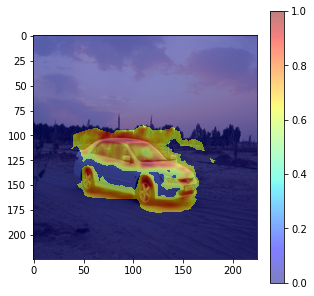

In [19]:
# AC-SISE
ac_sise = SISE(model, 'resnet50', '002153.jpg', 6, grouping_thr=0.1)
ac_sise.feature_extractor()
ac_sise.feature_filtering()
ac_sise.filtering_zero_feature_maps()
ac_sise.postprocess()
ac_sise.attribution_masks_compress()
ac_sise.generate_layer_visualization_map()
ac_sise.layers_fusion()

plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

64 -> 30, 34개 감소 (감소율: -53.125%)
256 -> 104, 152개 감소 (감소율: -59.375%)
512 -> 260, 252개 감소 (감소율: -49.21875%)
1024 -> 402, 622개 감소 (감소율: -60.7421875%)
2048 -> 590, 1458개 감소 (감소율: -71.19140625%)

Total
3904 -> 1386, 2518개 감소 (감소율: -64.49795081967213%)

64 -> 30, 34개 감소 (감소율: -53.125%)
256 -> 104, 152개 감소 (감소율: -59.375%)
512 -> 260, 252개 감소 (감소율: -49.21875%)
1024 -> 1, 1023개 감소 (감소율: -99.90234375%)
2048 -> 1, 2047개 감소 (감소율: -99.951171875%)

Total
3904 -> 396, 3508개 감소 (감소율: -89.85655737704919%)


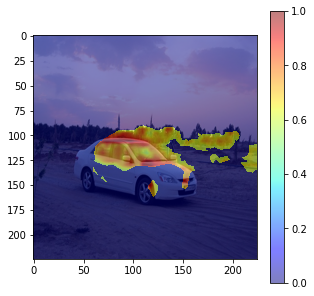

In [18]:
# new AC-SISE
ac_sise = SISE(model, 'resnet50', '002153.jpg', 6, grouping_thr=0.1)
ac_sise.feature_extractor()
ac_sise.feature_filtering()
ac_sise.filtering_zero_feature_maps()
ac_sise.postprocess()
ac_sise.new_attribution_masks_compress()
ac_sise.generate_layer_visualization_map()
ac_sise.layers_fusion()

plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

In [ ]:
# AC-SISE
ac_sise = SISE(model, 'resnet50', '000258.jpg', 11, grouping_thr=0.7)
ac_sise.feature_extractor()
ac_sise.feature_filtering()
ac_sise.filtering_zero_feature_maps()
ac_sise.postprocess()
# ac_sise.attribution_masks_compress()
# ac_sise.generate_layer_visualization_map()
# ac_sise.layers_fusion()

In [ ]:
# New AC-SISE
new_ac_sise = SISE(model, 'resnet50', '000258.jpg', 11, grouping_thr=0.5)
new_ac_sise.feature_extractor()
new_ac_sise.feature_filtering()
new_ac_sise.filtering_zero_feature_maps()
new_ac_sise.postprocess()
new_ac_sise.new_attribution_masks_compress()
new_ac_sise.generate_layer_visualization_map()
new_ac_sise.layers_fusion()

plt.figure(figsize=(5,5))
plt.imshow(new_ac_sise.img)
plt.imshow(normalization(new_ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

In [ ]:
# New AC-SISE
new_ac_sise = SISE(model, 'resnet50', '000258.jpg', 11, grouping_thr=0.7)
new_ac_sise.feature_extractor()
new_ac_sise.feature_filtering()
new_ac_sise.filtering_zero_feature_maps()
new_ac_sise.postprocess()
new_ac_sise.new_attribution_masks_compress()
# new_ac_sise.generate_layer_visualization_map()
# new_ac_sise.layers_fusion()

In [ ]:
group = ac_sise.group_bbox

In [ ]:
masks = ac_sise.postprocessed_feature_maps

In [ ]:
(score, diff) = ssim(masks['conv3'][:,:,5], masks['conv3'][:,:,469], full=True)

In [ ]:
score

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(masks['conv3'][:,:,5], cmap='gray')
axs[1].imshow(masks['conv3'][:,:,469], cmap='gray')

plt.show()

In [ ]:
group_index = 11

# 이미지 수
num_images = len(new_group['conv3'][group_index])

# 출력할 subplot의 행, 열 수 계산
num_cols = min(5, num_images)
num_rows = (num_images - 1) // num_cols + 1

# Figure 객체와 AxesSubplot 객체 생성
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# 이미지 출력
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx < num_images:
            (score, diff) = ssim(masks['conv3'][:,:,5], masks['conv3'][:,:,new_group['conv3'][group_index][idx]], full=True)
            axs[i,j].set_title(score)
            axs[i, j].imshow(masks['conv3'][:,:,new_group['conv3'][group_index][idx]], cmap='gray')
            axs[i, j].axis('off')
        axs[i,j].axis('off')

# 그래프 출력
plt.show()

In [ ]:
new_group

In [ ]:
# fms: [batch_size, height, width, channel=1]
def reduce_similar_fms(fms):
    # 유사한 feature map 그룹핑
    grouped_fms = []
    for i in range(fms.shape[0]):
        corr_fms = tf.reduce_sum(tf.multiply(fms[i], fms), axis=[1, 2]) # A @ B
        corr_fms = tf.abs(tf.divide(corr_fms, tf.norm(fms[i], axis=[0, 1]) * tf.norm(fms, axis=[1, 2])))
        # 자기 자신은 제외하고, 유사도가 0.9 이상인 것들끼리 그룹핑
        corr_fms = tf.tensor_scatter_nd_update(corr_fms, tf.expand_dims(tf.range(fms.shape[0]), axis=-1), tf.zeros([fms.shape[0]], dtype=tf.float32))
        grouped_fms.append(tf.greater(corr_fms, 0.7))
    grouped_fms = tf.stack(grouped_fms, axis=0)

    # 그룹핑된 피쳐맵들을 point-wise addition하여 피쳐맵의 수를 줄임
    reduced_fms = []
    for i in range(grouped_fms.shape[0]):
        fm_group = tf.boolean_mask(fms, grouped_fms[i], axis=0)
        reduced_fm = tf.reduce_sum(fm_group, axis=0, keepdims=True)
        reduced_fms.append(reduced_fm)
    reduced_fms = tf.concat(reduced_fms, axis=0)

    print("Original feature map shape:", fms.shape)
    print("Reduced feature map shape:", reduced_fms.shape)

    return reduced_fms


In [ ]:
reduce_similar_fms(np.transpose(ac_sise.postprocessed_feature_maps['conv3'], axes=(2,0,1)))

In [ ]:
fms = np.transpose(ac_sise.postprocessed_feature_maps['conv3'], axes=(2,0,1))

In [ ]:
for i in range(fms.shape[0]):
    corr_fms = tf.reduce_sum(tf.multiply(fms[i], fms), axis=[1, 2]) # A @ B
    corr_fms = tf.abs(tf.divide(corr_fms, tf.norm(fms[i], axis=[0, 1]) * tf.norm(fms, axis=[1, 2])))
    break

In [ ]:
def cosine_similarity(x1, x2):
    # reshape tensors to (batch_size, width * height)
    x1 = tf.reshape(x1, [x1.shape[0], -1])
    x2 = tf.reshape(x2, [x2.shape[0], -1])

    # calculate cosine similarity
    dot_product = tf.reduce_sum(tf.multiply(x1, x2), axis=1, keepdims=True)
    norm_x1 = tf.norm(x1, axis=1, keepdims=True)
    norm_x2 = tf.norm(x2, axis=1, keepdims=True)
    similarity = dot_product / (norm_x1 * norm_x2)

    return similarity


In [ ]:
cosine_similarity(fms, fms)

In [ ]:
fmaps = ac_sise.postprocessed_feature_maps

layers = ['conv3', 'conv4']

# IoU가 0.5 이상인 feature map끼리 grouping
compressed_feature_maps = {}
group_fmaps = {}
for k in layers:
    temp = fmaps[k].copy()
    group_fmaps[k] = []
    while temp.shape[2] != 0:
        base_fmap = temp[:,:,0]
        # group_fmaps[k].append([base_fmap])
        temp = np.delete(temp, 0, axis=2)
        temp_group = [base_fmap]
        temp_delete_group = []

        for i in range(temp.shape[2]):
            if ssim(base_fmap, temp[:,:,i], full=True)[0] >= 0.6:
                temp_group.append(temp[:,:,i])
                temp_delete_group.append(i)
                
        group_fmaps[k].append(temp_group)
        temp = np.delete(temp, temp_delete_group, axis=2)

group_fmaps = group_fmaps

In [ ]:
compressed_feature_maps = {}

for layer in layers:
    for b in group_fmaps[layer]:
        compressed_feature_map = None
        for feature_map_index in b:
            if i == 0:
                compressed_feature_map = feature_map_index
            else:
                compressed_feature_map += feature_map_index

        if layer in compressed_feature_maps:
            compressed_feature_maps[layer] = np.concatenate((compressed_feature_maps[layer], np.expand_dims(normalization(compressed_feature_map), axis=2)), axis=2)
        else:
            compressed_feature_maps[layer] = np.expand_dims(normalization(compressed_feature_map), axis=2)

    fmaps[layer] = compressed_feature_maps[layer]

# # 필터링 된 피쳐맵 수 비교
# sum1 = sum2 = 0
# for k1, k2 in zip(self.avg_grads.values(), fmaps.values()):
#     print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
#     sum1 += len(k1)
#     sum2 += k2.shape[-1]

# print('\nTotal')
# print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')
# self.total_reduction_rate = (sum2-sum1)/sum1*100

In [ ]:
fmaps['conv3'].shape

In [ ]:
for b in group_fmaps[layer]:
    compressed_feature_map = None #np.zeros_like(fmaps[layer][:,:,0].shape)
    for i, feature_map_index in enumerate(b):
        if i == 0:
            compressed_feature_map = feature_map_index
        else:
            compressed_feature_map += feature_map_index